## QK sparsity

In the SCFA paper, QK sparsity is used as a proof of concept where we randomly drop some of the QK indices.

In [1]:
import torch
from torch.nn import functional as F
from torch.utils.cpp_extension import load
import os

os.environ["TORCH_CUDA_ARCH_LIST"] = "8.6" # for our RTX 3090. Modify for your own GPU.
os.environ["MAX_JOBS"] = "16" # use some of Bentham's many cores
hash_attn_kernel = load(
    name="hash_attn", sources=[os.path.normpath(os.path.join(os.getcwd(), "../source/splashattn/splash_main.cpp")), 
                                  os.path.normpath(os.path.join(os.getcwd(), "../source/splashattn/splash.cu"))], 
                                  extra_cuda_cflags=["-O2"],
)

In [2]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
def reference_qk_sparse_attn(q, k, v, sm_scale: float = 1.0, indices_to_keep: torch.Tensor = None, keep_prob: float = 0.2):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    B, H, N, D = q.shape
    if indices_to_keep is None:
        indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
        indices_to_keep = torch.sort(indices_to_keep)[0]
    q_slice = q[..., indices_to_keep, :]
    k_slice = k[..., indices_to_keep, :]
    v_slice = v[..., indices_to_keep, :]
    n_slice = len(indices_to_keep)
    attn_scores = torch.matmul(q_slice, k_slice.transpose(-2, -1)) * sm_scale
    attn_mask = torch.ones(B, H, n_slice, n_slice, device = q.device, dtype = torch.bool)
    attn_mask = torch.tril(attn_mask, diagonal = 0)
    attn_scores = attn_scores.masked_fill(~attn_mask, float("-inf"))
    attn = F.softmax(attn_scores, dim=-1)
    # sns.heatmap(attn.cpu().numpy().squeeze(), annot = False, cmap = "viridis")
    # plt.show()
    # return
    attn = attn.nan_to_num(0.0) # some cols will be totally masked out and softmax will produce NaNs
    slice_out = torch.matmul(attn, v_slice)
    out = torch.zeros_like(q)
    out[..., indices_to_keep, :] = slice_out
    return out


q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
reference_qk_sparse_attn(q, k, v)

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.5263, -0.2566, -0.0893,  ...,  0.1613,  0.3889, -0.3991]]]],
       device='cuda:0')

### Our QK Sparse kernel:

In [3]:
def kernel_qk_sparse_attn(q, k, v, sm_scale: float = 1.0, indices_to_keep: torch.Tensor = None, keep_prob: float = 0.2):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    B, H, N, D = q.shape
    if indices_to_keep is None:
        indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
        indices_to_keep = torch.sort(indices_to_keep)[0]
    out = torch.zeros_like(q)
    q = q[..., indices_to_keep, :]
    k = k[..., indices_to_keep, :]
    v = v[..., indices_to_keep, :]
    Q_idx = torch.arange(N, device=q.device).view(1, 1, N)
    Q_idx = Q_idx.expand(B, H, N)[..., indices_to_keep].contiguous().int()
    K_idx = torch.arange(N, device=q.device).view(1, 1, N)
    K_idx = K_idx.expand(B, H, N)[..., indices_to_keep].contiguous().int()
    kernel_output = hash_attn_kernel.forward(q, k, v, Q_idx, K_idx, sm_scale)
    # print(out[..., indices_to_keep, :].shape, kernel_output.shape)
    out[..., indices_to_keep, :] = kernel_output
    return out

q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
kernel_qk_sparse_attn(q, k, v)

tensor([[[[-0.7843,  0.5450,  1.8523,  ..., -0.3887, -1.1342,  1.4150],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.3160, -0.1730,  0.0860,  ...,  0.6275, -0.2617,  0.6920],
          [ 0.6268, -0.3358, -1.1643,  ..., -1.0079,  0.5253,  0.8928]]]],
       device='cuda:0')

### Correctness check:

Mean absolute error:  tensor(1.0629e-08, device='cuda:0')


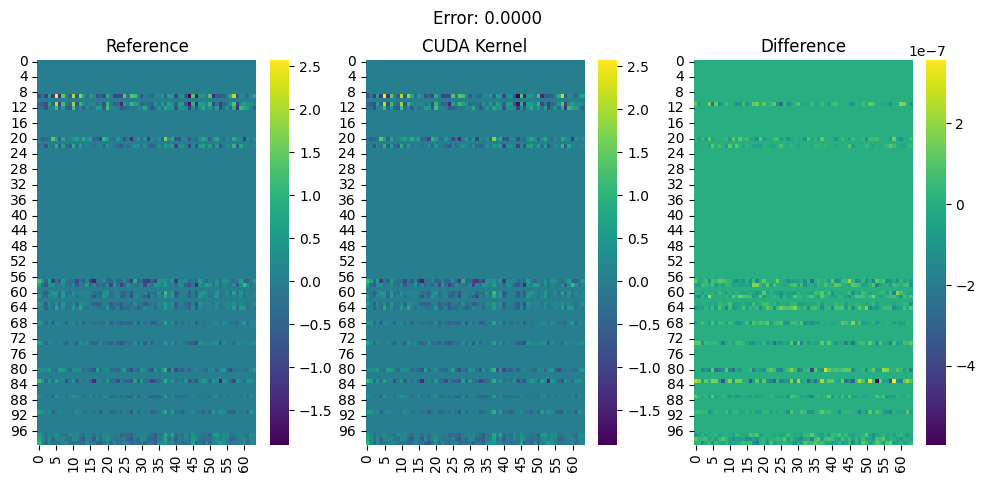

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
B = 1
H = 1
N = 100
D = 64
keep_prob = 0.2

q = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
k = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
v = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
indices_to_keep = torch.sort(indices_to_keep)[0]
reference_output = reference_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
kernel_output = kernel_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)

mae = (reference_output - kernel_output).abs().mean()
print("Mean absolute error: ", mae)
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
sns.heatmap(reference_output.squeeze().cpu().numpy(), annot = False, ax = axes[0], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy(), annot = False, ax = axes[1], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy() - reference_output.squeeze().cpu().numpy(), annot = False, ax = axes[2], cmap = "viridis")
axes[0].set_title("Reference")
axes[1].set_title("CUDA Kernel")
axes[2].set_title("Difference")
plt.suptitle(f"Error: {mae:.4f}")
plt.show()


### SCFA's Reference Implementation:

Mean absolute error:  tensor(7.3558e-05, device='cuda:0')


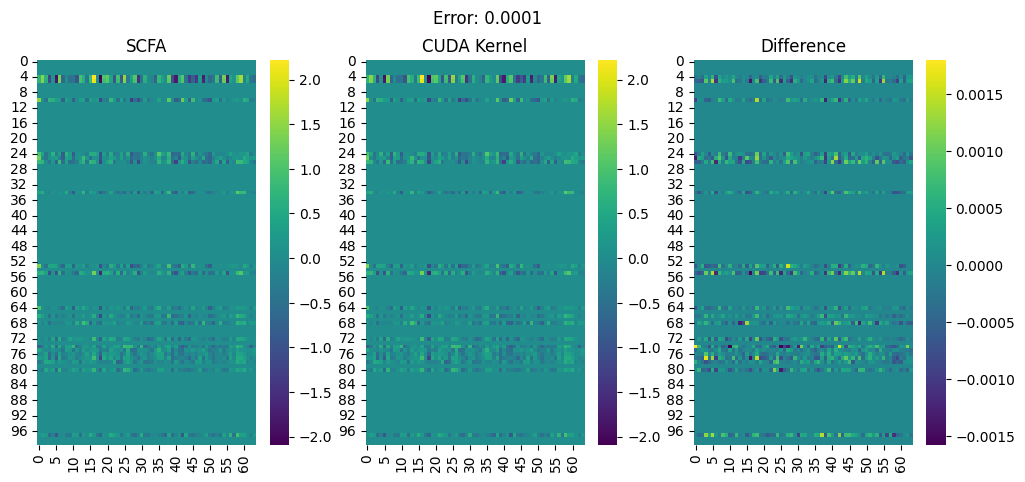

In [5]:
from source.scfa_paper.scfa_wrapper import qk_sparse_attention
import seaborn as sns
from matplotlib import pyplot as plt
B = 1
H = 1
N = 100
D = 64
keep_prob = 0.2

q = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
k = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
v = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
indices_to_keep = torch.sort(indices_to_keep)[0]
kernel_output = kernel_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)

def prep_scfa_input(q, k, v, indices_to_keep):
    # Prepare input for SCFA kernel
    B, H, N, D = q.shape
    binary_mask = torch.zeros(B, H, N, device = "cuda", dtype=torch.float32)
    binary_mask[:, :, indices_to_keep] = 1.0
    binary_mask = binary_mask.transpose(1, 2).contiguous() # (B, N, H) -> as SCFA expects
    scfa_q = q.clone().transpose(1, 2).contiguous() # (B, N, H, D) -> as SCFA expects
    scfa_k = k.clone().transpose(1, 2).contiguous()
    scfa_v = v.clone().transpose(1, 2).contiguous()

    return scfa_q, scfa_k, scfa_v, binary_mask

def prep_scfa_output(scfa_output):
    return scfa_output.transpose(1, 2)

scfa_q, scfa_k, scfa_v, binary_mask = prep_scfa_input(q, k, v, indices_to_keep)
scfa_output = qk_sparse_attention(scfa_q, scfa_k, scfa_v, 
                                q_keep = binary_mask.clone(), 
                                k_keep = binary_mask.clone(), 
                                sm_scale = 1.0 / math.sqrt(D))
scfa_output = prep_scfa_output(scfa_output)

mae = (kernel_output - scfa_output).abs().mean()
print("Mean absolute error: ", mae)
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
sns.heatmap(scfa_output.squeeze().cpu().numpy(), annot = False, ax = axes[0], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy(), annot = False, ax = axes[1], cmap = "viridis")
sns.heatmap(scfa_output.squeeze().cpu().numpy() - kernel_output.squeeze().cpu().numpy(), annot = False, ax = axes[2], cmap = "viridis")
axes[0].set_title("SCFA")
axes[1].set_title("CUDA Kernel")
axes[2].set_title("Difference")
plt.suptitle(f"Error: {mae:.4f}")
plt.show()


### Sanity Check (this should pass):

In [6]:
B = 1
H = 1
N = 100
D = 64
keep_prob = 0.2

q = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
k = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
v = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
indices_to_keep = torch.sort(indices_to_keep)[0]
kernel_output = kernel_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
reference_output = reference_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
scfa_q, scfa_k, scfa_v, binary_mask = prep_scfa_input(q, k, v, indices_to_keep)
scfa_output = qk_sparse_attention(scfa_q, scfa_k, scfa_v, 
                                q_keep = binary_mask.clone(), 
                                k_keep = binary_mask.clone(), 
                                sm_scale = 1.0 / math.sqrt(D))
scfa_output = prep_scfa_output(scfa_output)

print("Paper <> Reference Max Error: ", (scfa_output - reference_output).abs().max())
print("Reference <> CUDA Max Error: ", (reference_output - kernel_output).abs().max())
print("Paper <> CUDA Max Error: ", (kernel_output - scfa_output).abs().max())

assert (kernel_output - scfa_output).abs().max() < 5e-3, "SCFA and CUDA kernel outputs should match"
assert (kernel_output - reference_output).abs().max() < 5e-3, "CUDA kernel and reference outputs should match"
assert (scfa_output - reference_output).abs().max() < 5e-3, "SCFA and reference outputs should match"

Paper <> Reference Max Error:  tensor(0.0029, device='cuda:0')
Reference <> CUDA Max Error:  tensor(7.1526e-07, device='cuda:0')
Paper <> CUDA Max Error:  tensor(0.0029, device='cuda:0')


In [10]:
scfa_q.shape, scfa_k.shape, scfa_v.shape, binary_mask.shape

(torch.Size([1, 100, 1, 64]),
 torch.Size([1, 100, 1, 64]),
 torch.Size([1, 100, 1, 64]),
 torch.Size([1, 100, 1]))

### V2 CUDA Kernel

In [7]:
import torch
from torch.nn import functional as F
from torch.utils.cpp_extension import load
import os

os.environ["TORCH_CUDA_ARCH_LIST"] = "8.6" # for our RTX 3090. Modify for your own GPU.
os.environ["MAX_JOBS"] = "16" # use some of Bentham's many cores
qk_sparse_attn_kernel = load(
    name="qk_sparse_attn", sources=[os.path.normpath(os.path.join(os.getcwd(), "../source/v2/qk_sparse_forward.cu"))], 
                                  extra_cuda_cflags=["-O2"],
)

KeyboardInterrupt: 

In [17]:
def prep_v2_qk_sparse_input(q, k, v, indices_to_keep):
    # Prepare input for SCFA kernel
    B, H, N, D = q.shape
    binary_mask = torch.zeros(B, H, N, device = "cuda", dtype=torch.float32)
    binary_mask[:, :, indices_to_keep] = 1.0
    binary_mask = binary_mask.contiguous()
    qk_sparse_q = q.clone().contiguous()
    qk_sparse_k = k.clone().contiguous()
    qk_sparse_v = v.clone().contiguous()

    return qk_sparse_q, qk_sparse_k, qk_sparse_v, binary_mask

def v2_qk_sparse_attn(q, k, v, sm_scale: float = 1.0, indices_to_keep: torch.Tensor = None, keep_prob: float = 0.2):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    B, H, N, D = q.shape
    if indices_to_keep is None:
        indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
        indices_to_keep = torch.sort(indices_to_keep)[0]
    out = torch.zeros_like(q)
    q = q[..., indices_to_keep, :]
    k = k[..., indices_to_keep, :]
    v = v[..., indices_to_keep, :]
    Q_idx = torch.arange(N, device=q.device).view(1, 1, N)
    Q_idx = Q_idx.expand(B, H, N)[..., indices_to_keep].contiguous().int()
    K_idx = torch.arange(N, device=q.device).view(1, 1, N)
    K_idx = K_idx.expand(B, H, N)[..., indices_to_keep].contiguous().int()
    kernel_output = qk_sparse_attn_kernel.forward(q, k, v, Q_idx, K_idx, sm_scale)
    # print(out[..., indices_to_keep, :].shape, kernel_output.shape)
    out[..., indices_to_keep, :] = kernel_output
    return out

q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
v2_qk_sparse_attn(q, k, v)

TypeError: forward(): incompatible function arguments. The following argument types are supported:
    1. (arg0: torch.Tensor, arg1: torch.Tensor, arg2: torch.Tensor, arg3: torch.Tensor, arg4: torch.Tensor, arg5: torch.Tensor, arg6: torch.Tensor, arg7: float) -> torch.Tensor

Invoked with: tensor([[[[-3.2817e-01,  1.0995e+00, -2.3188e-01, -1.4735e+00, -8.5129e-02,
           -1.1699e+00,  1.3199e+00,  1.2410e+00,  1.6097e+00,  1.8640e+00,
            6.4827e-01, -3.6350e-01,  3.2482e-01,  3.0811e-01,  1.5844e+00,
           -6.7364e-01, -1.3385e+00, -2.6715e-01, -8.4553e-01, -1.7541e-01],
          [ 1.3351e+00,  8.8599e-01, -6.5773e-01, -3.8184e-01,  1.3704e+00,
            1.9507e-01,  1.9154e-01, -2.6385e-01, -3.1069e-01, -6.1143e-01,
            2.1041e-01,  1.0666e+00, -1.5282e+00, -2.4615e-01, -2.9603e-01,
           -9.5377e-01,  3.5310e-01, -7.1953e-01, -8.0354e-01,  1.8198e-01],
          [ 4.3792e-01,  6.0770e-02,  1.2666e-01, -8.2811e-01, -1.2430e+00,
           -3.0710e-01, -1.8161e+00, -1.8995e-01, -1.3374e+00,  2.2350e-02,
            2.0093e+00, -7.0901e-01, -6.3698e-01, -8.3485e-01, -9.9268e-01,
            4.3544e-01, -2.5018e+00,  1.7329e+00,  2.5849e-02, -2.0879e-01],
          [ 3.4831e+00, -8.9362e-01,  1.8673e-01,  8.8873e-02, -2.6793e+00,
           -2.3122e+00, -3.0005e-01,  1.1580e+00,  3.5428e-01, -9.8239e-01,
           -1.0578e-01, -8.7305e-01, -2.7147e-01, -6.6647e-01, -6.9637e-01,
            1.2274e+00, -1.9256e-01, -4.6181e-01,  2.2284e+00,  6.3748e-01],
          [-4.0215e-01, -5.4733e-01, -5.5792e-01,  1.0847e-01, -8.9743e-01,
           -7.7871e-01, -3.0552e+00,  3.4683e-01,  6.3213e-01, -9.6067e-01,
            2.8973e-01,  1.7182e+00,  1.2320e-02,  1.3035e-01, -1.7299e+00,
           -8.7159e-01, -4.4186e-01,  3.5784e-01, -1.3988e-01,  2.0012e-01],
          [ 7.6760e-02, -7.5136e-02, -4.4743e-01, -8.9021e-02, -6.0280e-01,
           -1.0233e+00, -1.4485e+00,  3.1461e-01,  1.7980e+00, -6.7437e-01,
           -6.2039e-01, -9.2938e-01, -4.4434e-01, -2.9603e-01, -5.5069e-01,
            1.0248e+00,  7.1863e-01, -1.9487e+00, -1.5738e+00, -2.1349e-01],
          [ 1.6430e-01, -6.5952e-01,  7.1166e-01, -1.2128e+00, -1.2501e-01,
           -1.8847e+00,  8.0830e-01, -1.0512e+00,  4.6743e-01,  6.7751e-01,
            1.3320e+00, -2.9843e-02, -2.4592e-01, -3.5094e-01,  5.5547e-01,
           -9.1174e-01, -6.2032e-01, -1.0486e+00,  6.4759e-01, -2.5704e+00],
          [ 4.6488e-02,  6.2528e-01, -6.2032e-02, -1.9452e+00,  2.0508e+00,
           -5.5951e-01, -1.0400e+00,  1.2473e+00, -3.1117e-01, -1.3459e-01,
            5.9944e-02, -1.0973e+00,  2.6397e-01, -6.8981e-01,  5.2694e-01,
           -2.5789e-01, -3.8010e-01, -8.3146e-01,  6.7250e-01, -2.8505e-03],
          [-5.3859e-01, -8.7468e-01,  8.4205e-01,  1.4997e-01,  1.1172e+00,
           -1.0053e-01,  1.2118e+00, -1.2199e+00,  6.3336e-01,  1.1195e+00,
           -1.2493e+00,  5.3210e-01,  1.8299e-01, -1.7363e-01, -4.9965e-01,
           -1.9203e-01, -5.0873e-01, -1.4665e+00,  1.7434e-01,  5.8792e-01],
          [ 8.7117e-01, -7.1074e-02,  7.5018e-01,  1.7053e+00,  1.1349e+00,
           -4.8370e-01, -1.4051e+00, -4.6496e-01,  1.3660e+00, -2.3849e-01,
           -2.2412e+00, -6.8642e-01,  1.8373e-01,  6.9513e-01,  2.2827e-01,
           -1.6598e-01,  1.3460e+00, -3.3339e-01,  6.3274e-01,  4.0699e-01],
          [ 4.5819e-01, -6.4566e-01, -1.2987e+00, -1.9629e-01, -8.5381e-01,
           -8.4157e-01,  1.0426e+00,  1.2751e+00,  4.2285e-01, -6.3860e-01,
           -2.1610e-01,  1.0458e+00,  3.4642e-01,  3.6191e-01,  1.3108e+00,
            4.5196e-01, -4.0716e-02, -8.1553e-01,  1.1488e+00,  2.6775e-01],
          [ 4.3477e-01,  9.6865e-01, -2.8697e-01,  3.3213e-01, -7.2957e-01,
            1.0219e+00,  1.7976e-01,  3.4797e-02, -1.1244e+00,  8.5743e-01,
           -1.5794e+00,  1.2161e-01, -4.0999e-01,  3.8166e-01, -8.6749e-01,
           -1.4153e+00, -1.0467e+00,  1.3579e+00, -9.9341e-01, -5.6328e-01],
          [-1.3003e+00,  8.0540e-01,  1.2968e+00,  1.3247e+00,  7.0878e-01,
           -1.2942e+00, -1.3706e+00, -5.8444e-01, -3.9037e-01,  8.1783e-01,
            2.4470e+00, -5.6507e-01, -2.1937e-01,  6.1868e-01,  1.8844e-01,
            3.7148e-01,  1.3329e+00, -1.3011e+00, -2.5310e-01,  8.3480e-01],
          [ 9.1621e-01,  2.1131e+00,  1.2965e+00,  1.5347e+00,  1.8647e-01,
           -4.1875e-01, -2.3110e+00, -4.5339e-01, -6.4692e-01, -2.9895e-01,
            6.1640e-01,  4.2410e-01,  5.1941e-01,  5.5702e-01, -5.7665e-01,
           -8.0705e-01,  2.0032e-01,  2.1027e+00, -1.7385e+00, -2.3664e+00],
          [ 7.8971e-02, -1.1051e+00, -1.3921e-01, -2.7495e-01, -3.0147e-01,
            4.8453e-01,  2.4297e-01,  8.9435e-02,  3.4303e+00, -3.7633e-01,
           -8.5622e-01,  1.8850e+00,  6.8686e-01,  1.0417e+00,  7.8449e-01,
            3.3047e-02,  6.7772e-02,  8.9163e-01, -8.2198e-01,  8.9239e-02],
          [-9.6282e-01, -1.0645e+00,  9.2970e-01, -9.9781e-01,  1.9854e-01,
           -5.8858e-01,  1.0666e+00,  1.2664e+00, -7.9466e-01, -5.2111e-01,
            3.6823e-01,  7.5988e-01,  9.1534e-01, -1.0663e+00,  5.2531e-01,
            5.3393e-01, -1.7391e+00,  1.7253e+00, -1.3849e-01,  8.2103e-01],
          [-1.5022e+00,  2.7409e+00, -4.5335e-01, -2.7350e-02, -1.1964e+00,
           -5.2973e-01, -4.2682e-01,  9.9856e-01,  1.5581e+00, -6.5358e-01,
           -1.3100e+00, -1.8808e-01, -1.3388e+00, -2.2605e-01,  1.5996e+00,
            2.0861e+00, -5.8502e-01,  1.9000e-01, -9.8191e-01, -1.5372e+00],
          [-1.6163e-01,  2.7971e-01,  8.1110e-01, -4.6441e-01,  2.1922e+00,
           -8.7436e-01,  3.3217e-01, -1.0193e+00, -5.5150e-01,  1.4860e+00,
            5.4705e-01, -1.0973e+00, -3.2545e-01,  6.4102e-01, -1.1156e+00,
           -1.4581e+00, -5.4636e-01,  6.5779e-01, -1.4930e+00, -4.6883e-02],
          [ 7.1194e-01,  2.2974e+00,  1.1097e+00, -6.2989e-01,  4.2579e-01,
           -7.4674e-01, -1.1212e+00,  1.1671e+00,  5.7983e-01,  6.9675e-01,
            2.9358e+00, -9.9632e-01, -4.2173e-01, -1.6481e-01,  3.7608e-01,
            5.1686e-02,  2.0369e+00,  1.0972e+00,  8.3110e-01,  1.0401e-02],
          [ 1.9418e+00, -1.7219e+00, -8.9361e-02, -5.7901e-01, -6.9541e-01,
           -7.2434e-01,  9.6459e-01,  2.6448e-01,  8.6898e-01, -8.8550e-01,
           -1.0763e+00, -5.7242e-01,  6.1907e-01, -1.2649e-01,  9.0887e-01,
           -8.3774e-01,  2.6077e+00, -4.5841e-01,  1.5082e+00,  5.6778e-01]]]],
       device='cuda:0'), tensor([[[[ 7.9930e-01, -1.2877e+00, -5.7773e-01,  9.9961e-01,  4.7790e-01,
            1.8769e+00, -3.2244e-01,  7.3746e-01, -2.0497e+00, -2.1822e+00,
           -2.8753e-01, -1.9329e+00,  1.9265e-01, -1.1243e+00, -1.2823e+00,
           -1.0837e+00,  1.2673e+00,  9.7691e-01, -2.0089e-01,  1.0452e+00],
          [-5.1871e-01,  4.9183e-01,  7.6291e-01,  1.7897e+00, -4.7906e-01,
            1.2461e+00, -2.4396e-01,  7.4180e-01,  8.1130e-01,  1.1233e-01,
           -6.2411e-01,  7.8980e-01, -1.4978e+00, -9.7072e-01, -8.5002e-01,
           -1.6844e+00,  1.3561e+00, -1.9265e+00,  5.0217e-01,  9.8798e-01],
          [-8.8162e-01,  1.1250e+00,  1.5045e+00,  2.2968e-01,  3.0981e+00,
            1.0608e+00, -4.0121e-01,  1.0439e+00,  1.9599e-01, -1.1722e+00,
           -7.9954e-01, -1.2874e+00,  1.1114e-01,  4.1019e-01,  1.3191e+00,
            4.2840e-01,  5.0777e-01,  7.5751e-01,  2.9993e+00,  1.3227e+00],
          [-7.6278e-01, -2.1443e-01,  2.8756e-01,  1.0796e+00, -1.6999e+00,
           -1.4722e+00, -5.2228e-01,  1.2865e+00,  1.6750e+00,  5.3026e-02,
            1.2118e-01, -2.1569e-01, -8.8908e-01, -4.2661e-01, -1.1871e+00,
           -7.4246e-01, -1.0832e+00, -2.5560e-01, -5.2681e-01, -3.5809e-01],
          [-8.2022e-01, -8.0154e-01,  6.2135e-01, -5.9973e-01,  1.0631e-01,
            9.2298e-02, -3.6976e-01, -7.4372e-01, -9.5588e-01,  6.5543e-01,
            3.9169e-01,  5.3680e-01,  1.9864e+00,  8.2244e-01, -1.5718e+00,
            6.8428e-01, -7.9977e-01, -1.1846e+00,  5.7256e-01,  7.0782e-01],
          [-8.2060e-01,  7.2335e-01, -3.4331e-01,  9.4135e-01, -9.5833e-01,
           -3.5841e-01, -7.1437e-02,  1.2060e+00, -9.7118e-01,  9.1101e-01,
           -1.1494e-01,  3.3751e-02,  7.6434e-01, -3.6373e-01, -4.8267e-01,
           -3.6301e-01,  2.0267e+00, -6.0426e-01, -5.1409e-01,  5.3475e-01],
          [-9.4529e-02, -1.3429e+00, -2.4570e+00,  1.5050e+00, -2.0642e+00,
            1.0286e-01, -8.1031e-01,  7.0024e-01,  1.3438e+00, -3.3206e-02,
           -8.8469e-01, -1.7477e-01, -4.1235e-02,  1.8332e+00, -3.6672e-01,
           -2.0356e+00,  4.9865e-01, -5.0458e-01, -3.2689e-01, -2.1415e-01],
          [-7.4915e-01, -4.0908e-01,  1.2347e+00,  1.5281e+00,  1.8718e-01,
            4.3816e-01, -1.4776e+00,  1.0228e+00,  4.7060e-01, -9.5410e-01,
           -9.2048e-01, -4.8932e-01,  8.0033e-01, -1.3060e-02, -1.1050e+00,
            1.2388e-01,  3.3721e-01,  7.7971e-01,  8.0465e-01, -4.4572e-02],
          [-8.8759e-01, -8.3894e-01,  8.7688e-01,  2.8909e+00, -7.0105e-01,
           -8.9566e-01, -5.1810e-01, -1.7421e-01,  8.6197e-01, -9.0504e-01,
           -1.1803e+00, -5.5022e-03, -1.5013e+00, -7.7976e-01,  6.4030e-01,
            2.8637e-01, -7.6997e-02,  6.0813e-01, -7.7773e-01,  1.1295e+00],
          [ 3.1959e-01, -9.9060e-01, -1.6408e-01,  4.2497e-01,  1.3045e+00,
            4.9477e-01, -1.8225e+00,  2.5977e-01,  1.1817e+00, -1.2306e+00,
           -1.2420e+00, -9.1452e-01, -1.2110e+00,  1.0058e+00, -1.0330e+00,
            5.6818e-01,  4.1299e-01,  1.5968e+00, -8.8077e-02,  2.8748e-02],
          [ 1.2686e+00,  7.9985e-01, -9.3607e-02,  9.1984e-01, -2.8597e-01,
            9.1280e-01, -5.8095e-01, -9.3602e-01, -8.8473e-01, -3.0739e-01,
           -6.7230e-01,  2.7791e-01,  1.2186e+00, -1.0734e+00, -1.2377e+00,
           -9.9339e-01, -2.3873e-01,  3.3154e-01,  1.1279e+00, -7.9548e-01],
          [-8.6414e-01, -1.2711e+00,  1.4773e+00, -1.1786e-01,  2.5248e-01,
           -4.1155e-01,  1.7193e+00, -7.4058e-01,  1.0680e+00, -1.0858e+00,
            5.4850e-01,  1.6840e+00, -1.6152e-02, -9.6440e-01,  2.8154e-01,
           -1.5982e-01, -1.6093e-01, -8.7873e-01,  1.6587e-02, -1.1947e+00],
          [ 1.2057e-01,  6.9499e-02, -6.9012e-01,  4.3248e-01, -6.9519e-01,
            9.3268e-01, -5.4426e-01,  2.1257e+00,  9.2504e-01, -2.7050e-01,
           -7.9249e-01, -9.3645e-01,  1.7105e+00,  1.0832e-02,  1.3544e+00,
            3.9519e-01, -6.7624e-01,  1.5365e+00, -8.6425e-02, -1.5655e+00],
          [-5.0158e-01,  9.0738e-01, -8.1268e-01,  5.3787e-02, -3.1877e-01,
            1.3116e+00, -8.9386e-01,  1.1933e+00,  1.7461e+00,  1.2823e+00,
           -1.6810e+00, -6.4339e-01,  1.4992e-02,  4.1365e-01,  6.2090e-02,
            4.0193e-01, -5.7175e-02, -7.3640e-01,  1.7880e-02, -5.7883e-01],
          [ 7.0417e-04,  1.8056e-01,  6.4623e-02, -8.7706e-01, -1.1201e+00,
           -5.1716e-01,  1.5209e+00,  7.6382e-01, -1.5922e+00,  2.9165e-01,
           -5.1480e-01,  1.5776e+00,  1.2496e+00,  6.6603e-01,  5.1599e-01,
            1.6609e+00,  4.1392e-01, -7.5786e-01,  4.0459e-01,  1.3755e+00],
          [ 1.4171e-01,  1.7711e+00,  2.5567e-01, -1.4620e+00, -8.2423e-01,
           -9.4348e-01,  5.5906e-01, -8.8184e-01,  1.6046e+00,  1.1481e+00,
            1.4081e+00, -4.1375e-01, -3.3518e-01,  1.4968e+00, -3.0524e-01,
           -6.8785e-01,  1.3195e+00,  1.1224e-01, -2.3145e-01, -4.7464e-01],
          [-8.7165e-01,  1.2615e+00, -3.2253e-01,  5.2829e-01, -1.3256e-01,
           -2.4664e-01, -2.0680e+00, -4.4626e-01, -9.2218e-01, -4.1461e-01,
            8.3956e-01,  4.1264e-01,  4.0401e-01,  6.7414e-01, -5.4581e-02,
           -1.0707e+00,  2.5515e-01,  7.2200e-02, -1.3728e-01, -2.1056e+00],
          [-1.5683e+00, -2.2222e-01, -3.7424e-01, -2.0905e+00,  9.0320e-01,
           -2.0799e-02,  8.1204e-01, -1.3318e+00,  1.2293e+00, -2.5705e-01,
           -5.2855e-01, -1.5546e+00, -1.4660e-01, -1.0913e+00,  3.0586e-02,
            6.3912e-02, -1.2980e+00,  6.1236e-01, -1.5387e+00, -3.9048e-01],
          [-2.5068e-01, -3.4443e-01,  7.6208e-01,  8.9641e-01,  4.2970e-01,
           -8.6449e-01, -3.1502e-01,  1.9573e+00,  6.7437e-01,  1.6559e-02,
            3.3930e-01, -1.8594e-01, -1.8800e+00,  1.6476e-01, -3.6402e-01,
            6.7351e-01, -7.7366e-02, -3.1851e-01,  9.4646e-01,  4.4113e-01],
          [ 4.7701e-01, -7.0255e-01,  1.7515e+00,  4.2491e-01,  3.3943e-01,
            1.2907e+00,  6.5729e-01, -6.3712e-01, -8.2198e-01, -6.1783e-01,
            1.4884e+00, -6.8185e-01, -8.6803e-01, -2.1878e-01, -5.2190e-03,
            3.3410e-01,  2.9295e-01, -1.7620e-01, -5.7887e-01, -6.6877e-01]]]],
       device='cuda:0'), tensor([[[[ 7.6709e-01,  1.0811e+00,  1.0150e+00, -8.9860e-01, -2.9288e-01,
           -4.6435e-01, -1.0901e+00, -1.1562e+00, -3.8355e-01,  3.3745e-01,
            1.6271e+00,  1.0000e+00, -8.5142e-01, -1.4246e-01, -2.5485e-01,
            6.9487e-01,  2.0704e+00, -7.2439e-01,  7.5070e-01, -5.4011e-01],
          [-7.5116e-01,  6.6020e-01, -4.9861e-01, -8.3588e-01,  2.8866e-01,
           -1.0740e+00, -3.8721e+00, -3.5658e-01, -5.4850e-01,  1.0051e+00,
            6.5831e-01,  5.8700e-01, -3.5786e-01, -2.9096e+00,  1.1712e+00,
            3.2735e-02, -1.5612e+00, -2.0053e+00, -9.6531e-01,  4.3610e-01],
          [ 2.5326e+00,  2.6718e-01, -7.0579e-01, -1.0569e+00,  6.5884e-01,
           -5.8493e-01, -1.0560e+00, -3.9697e-01, -1.4991e+00,  6.1115e-02,
            1.4113e-01,  1.1515e+00,  1.3365e+00, -1.0385e+00,  6.3828e-01,
           -1.4381e+00,  1.2512e+00, -1.3100e+00,  1.6136e+00, -6.8628e-01],
          [-6.0821e-01,  6.7453e-02,  1.7158e+00,  5.2356e-02, -1.2131e+00,
           -2.2753e-01, -5.0802e-01,  8.3808e-02, -8.4542e-01,  1.1034e+00,
            2.8124e-01,  1.0450e+00, -1.1738e-01,  8.9555e-01, -2.0575e+00,
            5.7477e-02, -1.6366e+00,  2.3580e+00, -1.2886e+00, -1.5446e+00],
          [ 5.1358e-01, -3.8774e-01, -1.0988e+00, -9.2212e-01,  3.5879e-01,
           -7.4552e-01,  2.5264e-01,  1.0089e+00,  9.1826e-01, -1.2204e-01,
           -1.9875e-01,  6.2874e-01,  3.0711e-01, -5.3039e-01,  2.4686e+00,
            6.2156e-01, -6.0430e-01,  6.7589e-02, -3.5723e-01, -6.2410e-01],
          [-2.1477e-01, -7.1068e-04, -1.1994e+00, -9.1808e-01, -1.0298e+00,
           -1.8136e+00,  1.4076e+00,  1.8169e-01,  6.0123e-01,  1.8476e-01,
            6.4607e-01, -5.6696e-01, -2.7013e-01, -1.3434e+00, -1.2017e-01,
           -1.5580e+00,  1.0536e+00, -1.7056e+00,  1.7979e-01,  8.5290e-01],
          [ 2.3373e-01, -1.5972e+00, -2.5845e-01,  8.7819e-01, -4.8343e-01,
           -1.5132e+00, -2.4040e-01, -5.4900e-01, -1.2925e+00,  2.4162e+00,
            9.4855e-01, -3.9573e-01, -2.1761e-01,  1.0587e+00, -8.6666e-01,
           -7.2585e-01, -3.7951e-01,  1.8783e-01, -1.2182e+00,  9.2677e-01],
          [-3.8949e-01,  1.0327e+00,  2.1276e+00,  8.7326e-01, -1.3168e+00,
           -1.0982e+00,  2.3813e+00, -1.5948e+00,  1.4074e-01, -1.5739e-01,
            8.8340e-01,  9.6655e-01, -1.9527e-01,  1.4449e+00, -1.0084e-01,
           -2.0034e+00,  6.2920e-01, -7.9129e-01, -3.3554e-01,  2.7461e-01],
          [ 4.3385e-01, -1.3893e+00, -1.3185e+00,  6.8259e-01, -6.5711e-01,
            4.6004e-01, -9.6710e-03,  3.7997e-01,  1.7144e-01, -5.0004e-02,
           -2.5371e+00, -8.8800e-01, -1.3097e-01, -3.5950e-01,  1.0647e+00,
           -6.7124e-01, -9.3067e-02,  9.5493e-03,  8.0037e-01,  8.3730e-01],
          [ 8.8133e-01,  5.7410e-02,  7.6853e-01,  3.8079e-01, -7.9321e-01,
            4.7810e-01,  2.9166e+00,  2.0771e-01,  5.6981e-01, -5.3053e-01,
           -1.7152e+00, -2.3310e-01,  3.2632e-01,  4.4118e-02, -8.6117e-02,
            5.7464e-01, -5.1488e-01, -5.3134e-01,  8.9096e-01,  2.0837e-01],
          [ 4.1509e-01,  5.2193e-01,  1.8398e-02,  7.7127e-01,  3.6809e-01,
           -1.8616e+00,  5.0142e-01,  7.9317e-01, -4.0336e-02, -1.0917e+00,
            8.1033e-01,  3.9634e-01, -9.9682e-01, -2.4939e-01, -1.5033e+00,
           -1.6379e+00, -7.2570e-01, -5.8969e-01,  3.1459e-01,  5.0804e-01],
          [-3.4345e-01,  1.2010e+00, -1.2746e+00,  1.5474e-01,  5.9712e-02,
           -1.2181e+00,  3.3694e-01,  1.7482e+00, -6.7757e-01,  6.7788e-01,
            2.0053e-01,  1.0721e+00,  3.9861e-01, -8.1357e-02, -2.0991e-01,
            3.2393e-01, -6.4493e-01, -6.0197e-01, -4.1244e-01,  6.3559e-01],
          [-8.8156e-01, -2.7741e-01,  1.5207e+00, -3.3368e-02,  6.2964e-01,
           -2.5622e-01, -1.4724e+00, -3.0206e-01, -3.2608e-01, -7.7911e-01,
            5.9600e-01,  2.3213e-01,  5.5812e-01,  6.9328e-01, -3.8539e-01,
            3.1682e-01,  2.1211e+00,  1.1677e+00, -1.1853e-04, -4.1435e-01],
          [ 1.6215e+00, -1.4611e+00, -1.1207e+00,  1.4076e+00, -3.1214e-01,
           -1.6987e+00,  6.2025e-01, -3.4809e-01,  7.5736e-01, -5.9187e-01,
            1.9571e-01,  4.1478e-01,  1.1116e+00,  2.6583e-01, -1.9118e-01,
           -9.2117e-01, -1.0423e+00,  1.5178e-01, -2.7054e-02,  1.7321e+00],
          [ 4.6751e-01,  1.1856e-01,  6.2968e-02,  1.0332e+00, -7.9818e-01,
           -5.2769e-01, -2.7906e-01, -3.6985e-01,  1.1600e-01, -1.1575e-01,
            7.3957e-01,  1.9899e+00, -6.8063e-02,  6.0757e-01, -3.8700e-01,
            1.1601e+00, -4.7397e-02,  1.6163e+00,  7.5843e-02,  2.0830e+00],
          [ 1.4646e+00, -7.9655e-01,  1.2393e+00,  6.7655e-01,  7.1608e-01,
            5.1100e-01, -8.1043e-01, -1.0455e+00,  1.1840e-01, -1.2208e+00,
            5.1535e-02,  1.5451e+00, -1.0774e+00,  9.3314e-01, -6.4600e-01,
            6.0094e-02, -4.0341e-01, -1.2161e+00, -1.9827e-01,  1.4676e-01],
          [ 5.7214e-02, -9.4952e-01,  8.1291e-01,  4.9971e-01,  1.2946e+00,
            1.3183e+00,  1.6354e-01, -3.0862e-01,  1.7561e+00, -1.3788e-01,
            6.1022e-01, -3.0840e-01,  3.1990e+00,  7.0750e-01,  3.5629e-01,
            1.9176e+00, -7.5751e-01,  2.9324e+00,  4.1425e-01,  2.4954e-01],
          [ 4.8200e-01,  7.8429e-01,  2.4796e-02,  5.9592e-01,  5.5813e-02,
            1.5561e-01,  1.0034e+00,  7.7835e-02, -3.9042e-02,  6.4679e-01,
            4.9095e-01,  1.9915e+00, -1.0558e+00,  6.1839e-01,  5.4788e-01,
           -5.9894e-01,  4.6650e-01,  4.0692e-01,  7.4190e-01, -5.3702e-01],
          [-4.0487e-01,  3.2802e-03, -7.2031e-02, -3.6550e-01,  1.2614e-01,
            3.2171e-01, -3.4808e-02, -5.4550e-01, -1.5887e+00, -1.8063e+00,
           -3.6329e-01, -7.2446e-01,  6.6683e-01,  6.2214e-01, -2.2540e-01,
           -4.9666e-01, -2.0634e+00, -5.6900e-01,  1.0014e+00, -6.5809e-01],
          [-2.8677e-01, -1.4758e+00, -4.2467e-01,  1.2181e+00,  1.2694e+00,
           -7.2175e-01,  9.9310e-01, -1.9981e-01,  3.0887e-01, -2.0659e+00,
           -1.0726e+00, -1.2766e+00,  1.2872e+00,  2.7092e-01,  6.6938e-01,
            1.4069e-01,  1.3399e-01, -1.0879e+00, -3.3931e+00, -1.5615e+00]]]],
       device='cuda:0'), tensor([[[ 0,  2, 11, 13, 14, 16, 19, 21, 23, 45, 46, 50, 51, 52, 58, 59, 72,
          85, 91, 94]]], device='cuda:0', dtype=torch.int32), tensor([[[ 0,  2, 11, 13, 14, 16, 19, 21, 23, 45, 46, 50, 51, 52, 58, 59, 72,
          85, 91, 94]]], device='cuda:0', dtype=torch.int32), 1.0

### Speed Comparison:

Benchmarking sequence length: 256
  Standard: 0.0001s
  Reference QK: 0.0003s
  Kernel QK: 0.0003s
  SCFA QK: 0.0006s
Benchmarking sequence length: 512
  Standard: 0.0001s
  Reference QK: 0.0003s
  Kernel QK: 0.0004s
  SCFA QK: 0.0006s
Benchmarking sequence length: 1024
  Standard: 0.0003s
  Reference QK: 0.0003s
  Kernel QK: 0.0006s
  SCFA QK: 0.0006s
Benchmarking sequence length: 2048
  Standard: 0.0008s
  Reference QK: 0.0003s
  Kernel QK: 0.0011s
  SCFA QK: 0.0007s
Benchmarking sequence length: 4096
  Standard: 0.0026s
  Reference QK: 0.0006s
  Kernel QK: 0.0023s
  SCFA QK: 0.0008s
Benchmarking sequence length: 8192
  Standard: 0.0088s
  Reference QK: 0.0023s
  Kernel QK: 0.0063s
  SCFA QK: 0.0012s
Benchmarking sequence length: 16384
  Standard: 0.0352s
  Reference QK: 0.0072s
  Kernel QK: 0.0198s
  SCFA QK: 0.0021s
Benchmarking sequence length: 32768
  Standard: 0.1496s
  Reference QK: 0.0296s
  Kernel QK: 0.0721s
  SCFA QK: 0.0051s


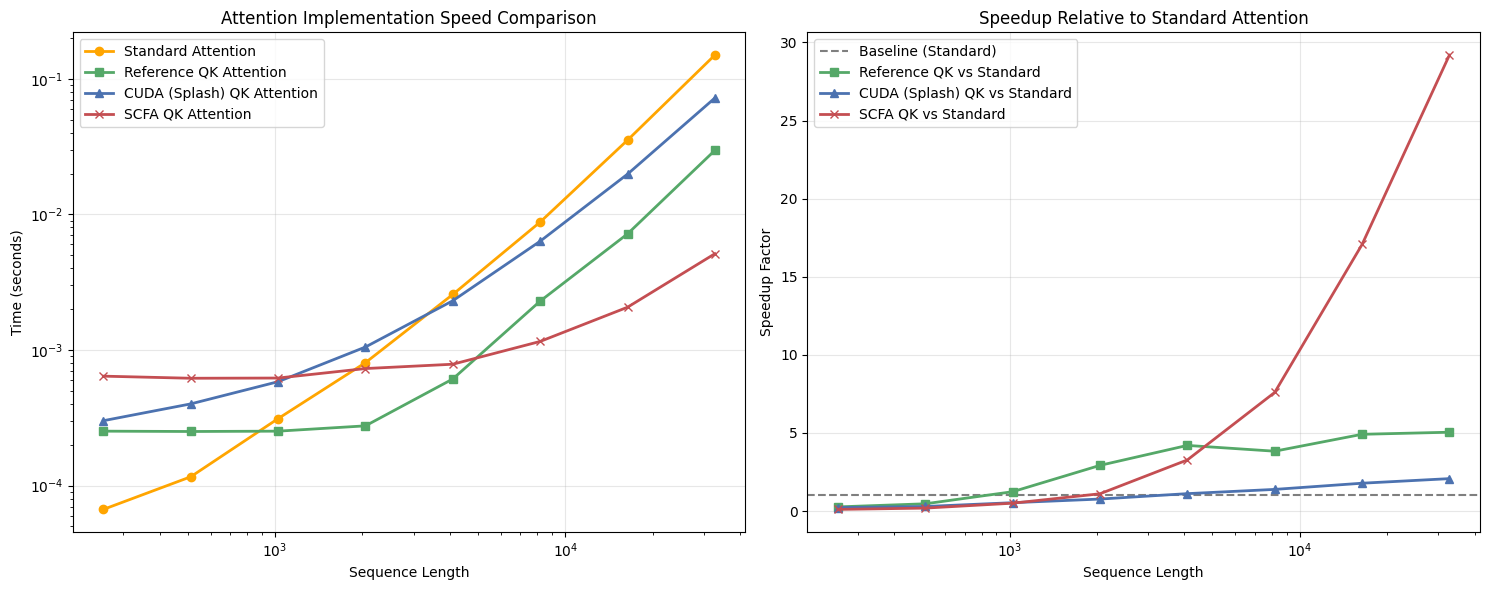


Benchmark Summary:
Seq Len    Standard (s)    Reference (s)   Kernel (s)      Ref Speedup  Kernel Speedup  SCFA (s)        SCFA Speedup   
--------------------------------------------------------------------------------
256        0.0001          0.0003          0.0003          0.26        x 0.22           x 0.0006          0.10           x
512        0.0001          0.0003          0.0004          0.46        x 0.29           x 0.0006          0.19           x
1024       0.0003          0.0003          0.0006          1.24        x 0.53           x 0.0006          0.50           x
2048       0.0008          0.0003          0.0011          2.92        x 0.77           x 0.0007          1.10           x
4096       0.0026          0.0006          0.0023          4.20        x 1.11           x 0.0008          3.27           x
8192       0.0088          0.0023          0.0063          3.83        x 1.38           x 0.0012          7.59           x
16384      0.0352          0.0072        

In [21]:
import time
import torch.nn.functional as F

# Benchmark code courtesy of Claude 4.0
def benchmark_attention_methods(seq_lens, d_model=64, num_heads=8, num_buckets=16, num_trials=10):
    """Benchmark different attention implementations across various sequence lengths."""
    results = {
        'seq_lens': [],
        'standard_attention': [],
        'reference_qk_attention': [],
        'kernel_qk_attention': [],
        'scfa_qk_attention': []
    }
    
    for seq_len in seq_lens:
        print(f"Benchmarking sequence length: {seq_len}")
        
        # Generate test data
        B, H, N, D = 1, num_heads, seq_len, d_model
        q = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        k = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        v = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        
        indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
        indices_to_keep = torch.sort(indices_to_keep)[0]
        
        # Warm up GPU
        for _ in range(3):
            _ = F.scaled_dot_product_attention(q, k, v, is_causal=True)
            _ = reference_qk_sparse_attn(q, k, v, sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
            _ = kernel_qk_sparse_attn(q, k, v, sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
        
        torch.cuda.synchronize()
        
        # Benchmark standard attention
        times_standard = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = F.scaled_dot_product_attention(q, k, v, is_causal=True)
            torch.cuda.synchronize()
            times_standard.append(time.time() - start_time)
        
        # Benchmark reference qk attention
        times_reference = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = reference_qk_sparse_attn(q, k, v, sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
            torch.cuda.synchronize()
            times_reference.append(time.time() - start_time)
        
        # Benchmark kernel qk attention
        times_kernel = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = kernel_qk_sparse_attn(q, k, v, sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
            torch.cuda.synchronize()
            times_kernel.append(time.time() - start_time)

        # Benchmark SCFA Triton qk attention
        times_scfa = []
        for _ in range(num_trials):
            scfa_q, scfa_k, scfa_v, binary_mask = prep_scfa_input(q, k, v, indices_to_keep)
            start_time = time.time()
            _ = qk_sparse_attention(scfa_q, scfa_k, scfa_v, 
                                q_keep = binary_mask.clone(), 
                                k_keep = binary_mask.clone(), 
                                sm_scale = 1.0 / math.sqrt(D))
            torch.cuda.synchronize()
            times_scfa.append(time.time() - start_time)
        
        # Store results (average times)
        results['seq_lens'].append(seq_len)
        results['standard_attention'].append(sum(times_standard) / len(times_standard))
        results['reference_qk_attention'].append(sum(times_reference) / len(times_reference))
        results['kernel_qk_attention'].append(sum(times_kernel) / len(times_kernel))
        results['scfa_qk_attention'].append(sum(times_scfa) / len(times_scfa))

        print(f"  Standard: {results['standard_attention'][-1]:.4f}s")
        print(f"  Reference QK: {results['reference_qk_attention'][-1]:.4f}s")
        print(f"  Kernel QK: {results['kernel_qk_attention'][-1]:.4f}s")
        print(f"  SCFA QK: {results['scfa_qk_attention'][-1]:.4f}s")
    return results

# Run benchmark
seq_lengths = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
benchmark_results = benchmark_attention_methods(seq_lengths)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Absolute times
ax1.plot(benchmark_results['seq_lens'], benchmark_results['standard_attention'], 'o-', label='Standard Attention', linewidth=2, color = "orange")
ax1.plot(benchmark_results['seq_lens'], benchmark_results['reference_qk_attention'], 's-', label='Reference QK Attention', linewidth=2, color = "#55A868")
ax1.plot(benchmark_results['seq_lens'], benchmark_results['kernel_qk_attention'], '^-', label='CUDA (Splash) QK Attention', linewidth=2, color = "#4C72B0")
ax1.plot(benchmark_results['seq_lens'], benchmark_results['scfa_qk_attention'], 'x-', label='SCFA QK Attention', linewidth=2, color = "#C44E52")
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Attention Implementation Speed Comparison')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup relative to standard attention
standard_times = benchmark_results['standard_attention']
reference_speedup = [std/ref for std, ref in zip(standard_times, benchmark_results['reference_qk_attention'])]
kernel_speedup = [std/ker for std, ker in zip(standard_times, benchmark_results['kernel_qk_attention'])]
scfa_speedup = [std/scfa for std, scfa in zip(standard_times, benchmark_results['scfa_qk_attention'])]

ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Baseline (Standard)')
ax2.plot(benchmark_results['seq_lens'], reference_speedup, 's-', label='Reference QK vs Standard', linewidth=2, color = "#55A868")
ax2.plot(benchmark_results['seq_lens'], kernel_speedup, '^-', label='CUDA (Splash) QK vs Standard', linewidth=2, color = "#4C72B0")
ax2.plot(benchmark_results['seq_lens'], scfa_speedup, 'x-', label='SCFA QK vs Standard', linewidth=2, color = "#C44E52")
ax2.set_xlabel('Sequence Length')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup Relative to Standard Attention')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
print("\nBenchmark Summary:")
print("=" * 80)
print(f"{'Seq Len':<10} {'Standard (s)':<15} {'Reference (s)':<15} {'Kernel (s)':<15} {'Ref Speedup':<12} {'Kernel Speedup':<15} {'SCFA (s)':<15} {'SCFA Speedup':<15}")
print("-" * 80)
for i, seq_len in enumerate(benchmark_results['seq_lens']):
    std_time = benchmark_results['standard_attention'][i]
    ref_time = benchmark_results['reference_qk_attention'][i]
    ker_time = benchmark_results['kernel_qk_attention'][i]
    scfa_time = benchmark_results['scfa_qk_attention'][i]
    ref_speedup = std_time / ref_time
    ker_speedup = std_time / ker_time
    scfa_speedup = std_time / scfa_time
    print(f"{seq_len:<10} {std_time:<15.4f} {ref_time:<15.4f} {ker_time:<15.4f} {ref_speedup:<12.2f}x {ker_speedup:<15.2f}x {scfa_time:<15.4f} {scfa_speedup:<15.2f}x")


## Locality-Sensitive Hashing
See mechanism described in the Reformer paper: https://arxiv.org/pdf/2001.04451

We hash $Q$ and $K$ into $B$ buckets by using a random matrix $R \in \mathbb{R}^{d \times b/2}$ and taking $\argmax([xR; −xR])$. As per the Johnson-Lindenstrauss lemma, this maps $Q$ and $K$ into a $b/2$-dimensional space in a relative-distance preserving way.

In [8]:
def vector_hash_fn(x: torch.Tensor, num_buckets: int, R: torch.Tensor) -> torch.Tensor:
    """
    x: (..., D)
    R: (D, b/2)
    """
    D = x.shape[-1]
    assert R.shape == (D, num_buckets // 2)
    return torch.argmax(torch.cat([x @ R, -x @ R], dim=-1), dim=-1)

def get_vector_hash(D: int, num_buckets: int, device: torch.device = "cpu") -> torch.Tensor:
    R = torch.randn(D, num_buckets // 2, device = device)
    return lambda x: vector_hash_fn(x, num_buckets, R)

vector_hash = get_vector_hash(D = 10, num_buckets = 10)
vector_hash(torch.randn(50, 10))

tensor([9, 9, 4, 6, 8, 7, 8, 7, 0, 2, 2, 3, 5, 5, 2, 2, 7, 5, 5, 7, 2, 0, 7, 0,
        6, 3, 1, 3, 1, 2, 8, 7, 4, 3, 8, 2, 1, 2, 0, 0, 0, 0, 0, 6, 5, 8, 3, 1,
        8, 8])

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
def reference_hash_attn(q, k, v, num_buckets: int, sm_scale: float = 1.0, vector_hash = None):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)

    Note: This implementation sucks! It's just a sanity check.
    """
    assert num_buckets % 2 == 0, "num_buckets must be even"
    if vector_hash is None:
        vector_hash = get_vector_hash(D = q.shape[-1], num_buckets = num_buckets, device = q.device)
    B, H, N, D = q.shape
    q_hashes = vector_hash(q) # (B, H, N)
    k_hashes = vector_hash(k) # (B, H, N)
    out = torch.zeros_like(q)
    for i in range(num_buckets):
        for b in range(B):
            for h in range(H):
                q_mask = (q_hashes[b][h] == i) # (N)
                k_mask = (k_hashes[b][h] == i) # (N)
                q_indices = torch.nonzero(q_mask, as_tuple=False).squeeze() # (N)
                k_indices = torch.nonzero(k_mask, as_tuple=False).squeeze() # (N)
                if q_indices.numel() == 0 or k_indices.numel() == 0:
                    continue
                q_bucket = q[b, h, q_indices] # (N, D)
                k_bucket = k[b, h, k_indices] # (N, D)
                v_bucket = v[b, h, k_indices] # (N, D)
                attn_mask = q_indices.unsqueeze(-1) >= k_indices.unsqueeze(-2)
                attn_scores = torch.matmul(q_bucket, k_bucket.transpose(-2, -1)) * sm_scale
                attn_scores = attn_scores.masked_fill(~attn_mask, float("-inf"))
                attn = F.softmax(attn_scores, dim=-1)
                attn = attn.nan_to_num(0.0) # some cols will be totally masked out and softmax will produce NaNs
                # sns.heatmap(attn.cpu().numpy().squeeze(), annot = False, mask = ~attn_mask.cpu().numpy().squeeze())
                # plt.show()
                # return
                partial_prod = torch.matmul(attn, v_bucket)
                out[b, h, q_indices] += partial_prod
    return out

q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
reference_hash_attn(q, k, v, num_buckets=4)

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 1.7249, -1.4868,  0.9274,  ...,  0.1850,  0.0963, -0.0610],
          [ 1.5566, -0.3067, -1.5795,  ..., -0.8642,  1.6696, -0.0125],
          [ 0.6514, -0.1777, -0.5839,  ...,  0.2715,  0.0168, -0.2919]]]],
       device='cuda:0')

## Comparison with our CUDA kernel:

In [10]:
def kernel_hash_attn(q, k, v, num_buckets: int, sm_scale: float = 1.0, vector_hash = None):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    assert num_buckets % 2 == 0, "num_buckets must be even"
    if vector_hash is None:
        vector_hash = get_vector_hash(D = q.shape[-1], num_buckets = num_buckets, device = q.device)
    B, H, N, D = q.shape
    q_hashes = vector_hash(q) # (B, H, N)
    k_hashes = vector_hash(k) # (B, H, N)
    Q_idx = torch.arange(N, device=q.device).view(1, 1, N)
    Q_idx = Q_idx.expand(B, H, N).contiguous().int()
    K_idx = torch.arange(N, device=q.device).view(1, 1, N)
    K_idx = K_idx.expand(B, H, N).contiguous().int()
    max_q_size, max_k_size = 0, 0
    out = torch.zeros_like(q)
    for i in range(num_buckets):
        for b in range(B):
            for h in range(H):
                num_q = (q_hashes[b][h] == i).sum() # (N)
                num_k = (k_hashes[b][h] == i).sum() # (N)
                max_q_size = max(max_q_size, num_q)
                max_k_size = max(max_k_size, num_k)
        q_tensor = torch.zeros(B, H, max_q_size, D, device = q.device, dtype=torch.float32)
        k_tensor = torch.zeros(B, H, max_k_size, D, device = q.device, dtype=torch.float32)
        v_tensor = torch.zeros(B, H, max_k_size, D, device = q.device, dtype=torch.float32)
        q_idx_tensor = torch.zeros(B, H, max_q_size, device = q.device, dtype=torch.int32)
        k_idx_tensor = torch.zeros(B, H, max_k_size, device = q.device, dtype=torch.int32)
        pad_mask_q = torch.zeros(B, H, max_q_size, device = q.device, dtype=torch.bool)
        for b in range(B):
            for h in range(H):
                q_mask = (q_hashes[b][h] == i)
                k_mask = (k_hashes[b][h] == i)
                num_q = q_mask.sum()
                num_k = k_mask.sum()
                q_tensor[b, h, :num_q] = q[b, h, q_mask]
                k_tensor[b, h, :num_k] = k[b, h, k_mask]
                v_tensor[b, h, :num_k] = v[b, h, k_mask]
                q_idx_tensor[b, h, :num_q] = Q_idx[b, h, q_mask]
                k_idx_tensor[b, h, :num_k] = K_idx[b, h, k_mask]
                pad_mask_q[b, h, :num_q] = True

        # Note that, at this point, q_idx_tensor and k_idx_tensor should already be sorted due to their initialization with arange
        q_tensor, q_idx_tensor, k_tensor, k_idx_tensor = q_tensor.contiguous(), q_idx_tensor.contiguous(), k_tensor.contiguous(), k_idx_tensor.contiguous()
        kernel_out = hash_attn_kernel.forward(q_tensor, k_tensor, v_tensor, q_idx_tensor, k_idx_tensor, sm_scale)
        kernel_out = kernel_out.masked_fill(~pad_mask_q.unsqueeze(-1), 0.0)
        # print(kernel_out.shape, max_q_size, max_k_size, q_idx_tensor.shape, k_idx_tensor.shape, q_tensor.shape, k_tensor.shape)
        # print(q_idx_tensor)
        batch_idx = torch.arange(B).view(B, 1, 1).expand(B, H, max_q_size)
        head_idx = torch.arange(H).view(1, H, 1).expand(B, H, max_q_size)
        out[batch_idx, head_idx, q_idx_tensor] += kernel_out
    return out

q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
kernel_hash_attn(q, k, v, num_buckets=4)

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 1.6399,  0.6183, -1.7281,  ..., -0.0187,  0.3821,  0.5776],
          ...,
          [ 0.2373, -0.2331, -1.1200,  ...,  0.2453,  0.1556, -0.6723],
          [-0.1673,  0.3366, -0.1198,  ...,  0.4100, -0.6144, -0.0372],
          [ 0.1995, -0.6807, -0.4262,  ..., -0.8846,  0.3013, -0.2268]]]],
       device='cuda:0')

### Correctness check:

Mean absolute error:  tensor(0.0085, device='cuda:0')


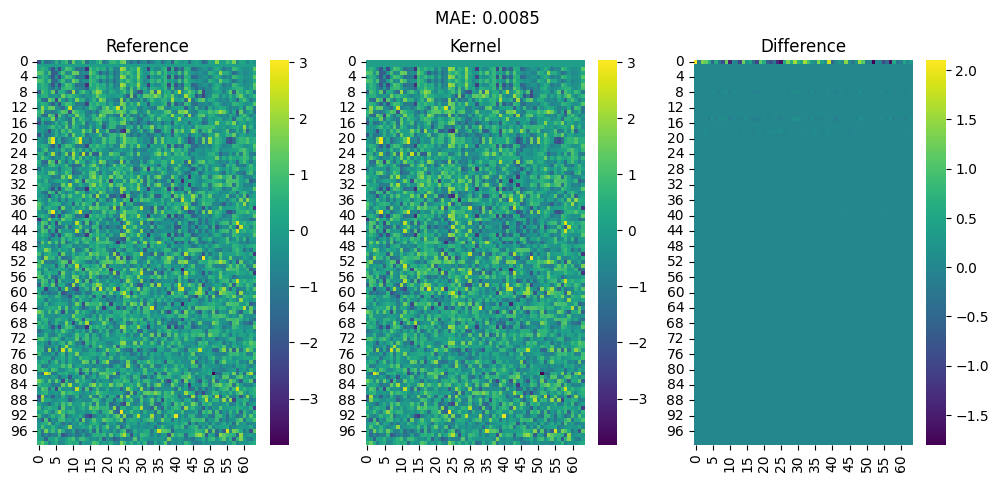

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
D = 64
q = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.float32)
standard_vector_hash = get_vector_hash(D = D, num_buckets = 4, device = "cuda")
reference_output =reference_hash_attn(q, k, v, num_buckets = 4, vector_hash = standard_vector_hash)
kernel_output = kernel_hash_attn(q, k, v, num_buckets = 4, vector_hash = standard_vector_hash)

mae = (reference_output - kernel_output).abs().mean()
print("Mean absolute error: ", mae)
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
sns.heatmap(reference_output.squeeze().cpu().numpy(), annot = False, ax = axes[0], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy(), annot = False, ax = axes[1], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy() - reference_output.squeeze().cpu().numpy(), annot = False, ax = axes[2], cmap = "viridis")
axes[0].set_title("Reference")
axes[1].set_title("Kernel")
axes[2].set_title("Difference")
plt.suptitle(f"MAE: {mae:.4f}")
plt.show()


### SCFA's Reference Hash Attention:

Mean absolute error:  tensor(0.0006, device='cuda:0')


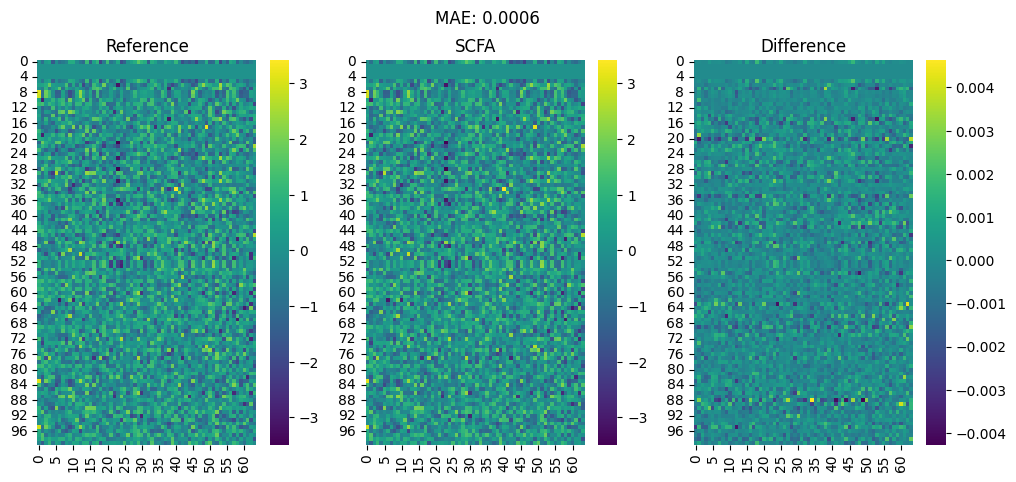

In [18]:
import seaborn as sns
from matplotlib import pyplot as plt
from source.scfa_paper.scfa_wrapper import hash_sparse_attention

def scfa_hash_attn(q, k, v, num_buckets: int, sm_scale: float = 1.0, vector_hash = None):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    B, H, N, D = q.shape
    if vector_hash is None:
        vector_hash = get_vector_hash(D = D, num_buckets = num_buckets, device = q.device)
    q_hashes = vector_hash(q).to(torch.int32).transpose(1, 2).contiguous() # (B, N, H)
    k_hashes = vector_hash(k).to(torch.int32).transpose(1, 2).contiguous() # (B, N, H)
    scfa_q = q.transpose(1, 2).contiguous() # (B, N, H, D)
    scfa_k = k.transpose(1, 2).contiguous() # (B, N, H, D)
    scfa_v = v.transpose(1, 2).contiguous() # (B, N, H, D)
    return hash_sparse_attention(scfa_q, scfa_k, scfa_v, q_hashes, k_hashes, sm_scale).transpose(1, 2).contiguous()

q = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.float32)
standard_vector_hash = get_vector_hash(D = D, num_buckets = 4, device = "cuda")
reference_output =reference_hash_attn(q, k, v, num_buckets = 4, vector_hash = standard_vector_hash)
scfa_output = scfa_hash_attn(q, k, v, num_buckets = 4, vector_hash = standard_vector_hash)

mae = (reference_output - scfa_output).abs().mean()
print("Mean absolute error: ", mae)
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
sns.heatmap(reference_output.squeeze().cpu().numpy(), annot = False, ax = axes[0], cmap = "viridis")
sns.heatmap(scfa_output.squeeze().cpu().numpy(), annot = False, ax = axes[1], cmap = "viridis")
sns.heatmap(scfa_output.squeeze().cpu().numpy() - reference_output.squeeze().cpu().numpy(), annot = False, ax = axes[2], cmap = "viridis")
axes[0].set_title("Reference")
axes[1].set_title("SCFA")
axes[2].set_title("Difference")
plt.suptitle(f"MAE: {mae:.4f}")
plt.show()


## Speed comparison:

Benchmarking sequence length: 256
  Standard: 0.0001s
  Reference Hash: 0.0323s
  Kernel Hash: 0.0649s
  SCFA Hash: 0.0005s
Benchmarking sequence length: 512
  Standard: 0.0001s
  Reference Hash: 0.0325s
  Kernel Hash: 0.0657s
  SCFA Hash: 0.0005s
Benchmarking sequence length: 1024
  Standard: 0.0003s
  Reference Hash: 0.0327s
  Kernel Hash: 0.0673s
  SCFA Hash: 0.0005s
Benchmarking sequence length: 2048
  Standard: 0.0008s
  Reference Hash: 0.0329s
  Kernel Hash: 0.0693s
  SCFA Hash: 0.0007s
Benchmarking sequence length: 4096
  Standard: 0.0026s
  Reference Hash: 0.0332s
  Kernel Hash: 0.0739s
  SCFA Hash: 0.0010s
Benchmarking sequence length: 8192
  Standard: 0.0088s
  Reference Hash: 0.0345s
  Kernel Hash: 0.0921s
  SCFA Hash: 0.0025s
Benchmarking sequence length: 16384
  Standard: 0.0352s
  Reference Hash: 0.0358s
  Kernel Hash: 0.1329s
  SCFA Hash: 0.0073s
Benchmarking sequence length: 32768
  Standard: 0.1490s
  Reference Hash: 0.0699s
  Kernel Hash: 0.2664s
  SCFA Hash: 0.0253s


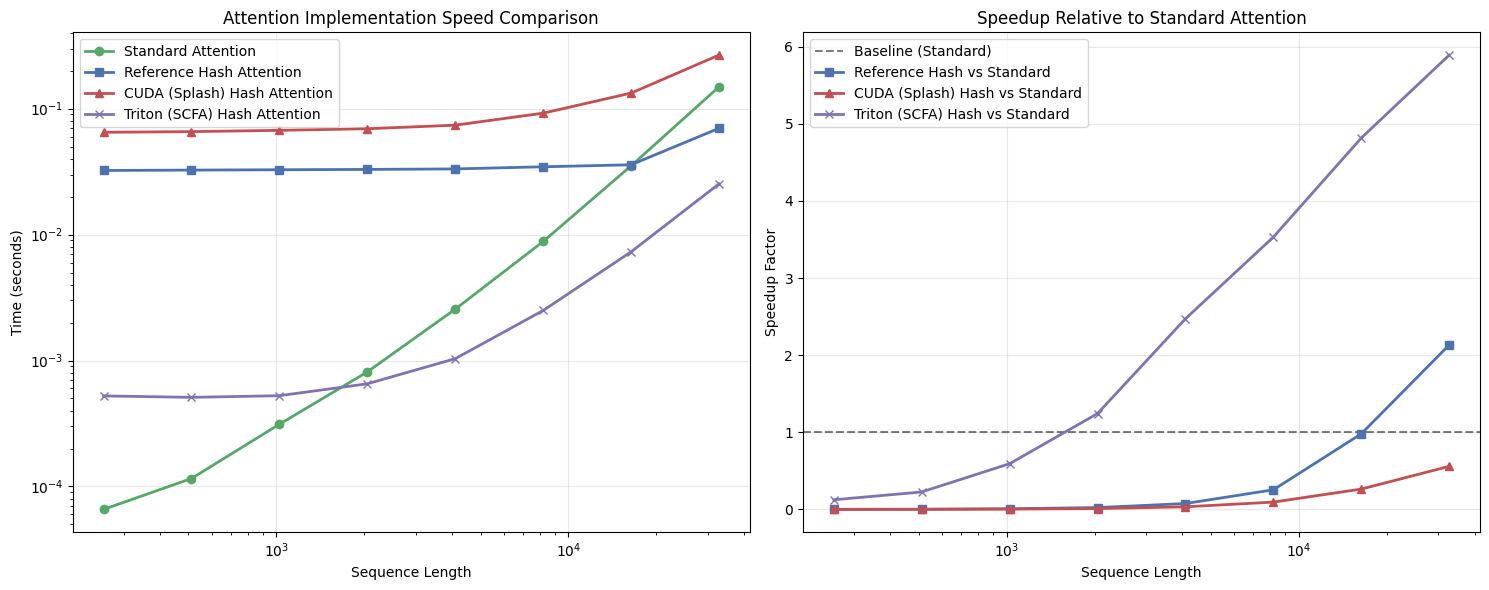


Benchmark Summary:
Seq Len    Standard (s)    Reference (s)   Kernel (s)      Ref Speedup  Kernel Speedup  SCFA (s)        SCFA Speedup   
--------------------------------------------------------------------------------
256        0.0001          0.0323          0.0649          0.00        x 0.00           x 0.0005          0.13           x
512        0.0001          0.0325          0.0657          0.00        x 0.00           x 0.0005          0.23           x
1024       0.0003          0.0327          0.0673          0.01        x 0.00           x 0.0005          0.59           x
2048       0.0008          0.0329          0.0693          0.02        x 0.01           x 0.0007          1.24           x
4096       0.0026          0.0332          0.0739          0.08        x 0.03           x 0.0010          2.47           x
8192       0.0088          0.0345          0.0921          0.26        x 0.10           x 0.0025          3.53           x
16384      0.0352          0.0358        

In [22]:
import time
import torch.nn.functional as F

# Benchmark code courtesy of Claude 4.0
def benchmark_attention_methods(seq_lens, d_model=64, num_heads=8, num_buckets=16, num_trials=10):
    """Benchmark different attention implementations across various sequence lengths."""
    results = {
        'seq_lens': [],
        'standard_attention': [],
        'reference_hash_attention': [],
        'kernel_hash_attention': [],
        'scfa_hash_attention': []
    }
    
    for seq_len in seq_lens:
        print(f"Benchmarking sequence length: {seq_len}")
        
        # Generate test data
        B, H, N, D = 1, num_heads, seq_len, d_model
        q = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        k = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        v = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        
        # Create shared vector hash for fair comparison
        standard_vector_hash = get_vector_hash(D=D, num_buckets=num_buckets, device="cuda")
        
        # Warm up GPU
        for _ in range(3):
            _ = F.scaled_dot_product_attention(q, k, v, is_causal=True)
            _ = reference_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
            _ = kernel_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
        
        torch.cuda.synchronize()
        
        # Benchmark standard attention
        times_standard = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = F.scaled_dot_product_attention(q, k, v, is_causal=True)
            torch.cuda.synchronize()
            times_standard.append(time.time() - start_time)
        
        # Benchmark reference hash attention
        times_reference = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = reference_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
            torch.cuda.synchronize()
            times_reference.append(time.time() - start_time)
        
        # Benchmark kernel hash attention
        times_kernel = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = kernel_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
            torch.cuda.synchronize()
            times_kernel.append(time.time() - start_time)

        # Benchmark SCFA hash attention
        times_scfa = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = scfa_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
            torch.cuda.synchronize()
            times_scfa.append(time.time() - start_time)
        
        # Store results (average times)
        results['seq_lens'].append(seq_len)
        results['standard_attention'].append(sum(times_standard) / len(times_standard))
        results['reference_hash_attention'].append(sum(times_reference) / len(times_reference))
        results['kernel_hash_attention'].append(sum(times_kernel) / len(times_kernel))
        results['scfa_hash_attention'].append(sum(times_scfa) / len(times_scfa))

        print(f"  Standard: {results['standard_attention'][-1]:.4f}s")
        print(f"  Reference Hash: {results['reference_hash_attention'][-1]:.4f}s")
        print(f"  Kernel Hash: {results['kernel_hash_attention'][-1]:.4f}s")
        print(f"  SCFA Hash: {results['scfa_hash_attention'][-1]:.4f}s")
    return results

# Run benchmark
seq_lengths = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
benchmark_results = benchmark_attention_methods(seq_lengths)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Absolute times
ax1.plot(benchmark_results['seq_lens'], benchmark_results['standard_attention'], 'o-', label='Standard Attention', linewidth=2, color = "#55A868")
ax1.plot(benchmark_results['seq_lens'], benchmark_results['reference_hash_attention'], 's-', label='Reference Hash Attention', linewidth=2, color = "#4C72B0")
ax1.plot(benchmark_results['seq_lens'], benchmark_results['kernel_hash_attention'], '^-', label='CUDA (Splash) Hash Attention', linewidth=2, color = "#C44E52")
ax1.plot(benchmark_results['seq_lens'], benchmark_results['scfa_hash_attention'], 'x-', label='Triton (SCFA) Hash Attention', linewidth=2, color = "#8172B2")
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Attention Implementation Speed Comparison')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup relative to standard attention
standard_times = benchmark_results['standard_attention']
reference_speedup = [std/ref for std, ref in zip(standard_times, benchmark_results['reference_hash_attention'])]
kernel_speedup = [std/ker for std, ker in zip(standard_times, benchmark_results['kernel_hash_attention'])]
scfa_speedup = [std/scfa for std, scfa in zip(standard_times, benchmark_results['scfa_hash_attention'])]

ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Baseline (Standard)')
ax2.plot(benchmark_results['seq_lens'], reference_speedup, 's-', label='Reference Hash vs Standard', linewidth=2, color = "#4C72B0")
ax2.plot(benchmark_results['seq_lens'], kernel_speedup, '^-', label='CUDA (Splash) Hash vs Standard', linewidth=2, color = "#C44E52")
ax2.plot(benchmark_results['seq_lens'], scfa_speedup, 'x-', label='Triton (SCFA) Hash vs Standard', linewidth=2, color = "#8172B2")
ax2.set_xlabel('Sequence Length')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup Relative to Standard Attention')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
print("\nBenchmark Summary:")
print("=" * 80)
print(f"{'Seq Len':<10} {'Standard (s)':<15} {'Reference (s)':<15} {'Kernel (s)':<15} {'Ref Speedup':<12} {'Kernel Speedup':<15} {'SCFA (s)':<15} {'SCFA Speedup':<15}")
print("-" * 80)
for i, seq_len in enumerate(benchmark_results['seq_lens']):
    std_time = benchmark_results['standard_attention'][i]
    ref_time = benchmark_results['reference_hash_attention'][i]
    ker_time = benchmark_results['kernel_hash_attention'][i]
    ref_speedup = std_time / ref_time
    ker_speedup = std_time / ker_time
    scfa_time = benchmark_results['scfa_hash_attention'][i]
    scfa_speedup = std_time / scfa_time
    print(f"{seq_len:<10} {std_time:<15.4f} {ref_time:<15.4f} {ker_time:<15.4f} {ref_speedup:<12.2f}x {ker_speedup:<15.2f}x {scfa_time:<15.4f} {scfa_speedup:<15.2f}x")
